<a href="https://colab.research.google.com/github/rohanwagh01/036-MachineLearning/blob/main/hw10colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this homework, you will need to understand the notes on <a target="_blank" href="https://canvas.mit.edu/courses/11118/files/1788187?module_item_id=404509">k-means clustering</a>.

# K-Means Clustering

Previously, we've seen ways to develop models for supervised learning where we have access to labels, categories, or some other ground-truth values we can use to learn relationships in our data. We also saw how auto-encoders could be used to perform unsupervised learning of low-dimensional data representations.

This week, we introduce the k-means clustering algorithm -- another example of an unsupervised learning algorithm. The idea behind clustering is to divide your datapoints into groups (clusters) such that datapoints in each group are more similar to each other than datapoints in other clusters. Clustering is used in many fields for data exploration.

Even though methodologically, the k-means algorithm is much simpler than e.g. learning an auto-encoder, there are several important choices we have to keep in mind when implementing the k-means clustering algorithm:

1. How do we initialize initial cluster configurations?
2. How do we choose the number of clusters?
3. How do we choose what distance metric to use?
2. How do we evaluate the results of the output of the k-means clustering algorithm?

For the sake of the homework, we'll default to using the Euclidean distance as the form of measurement of distance for our model. We'll explore all of the rest of the attributes in the homework below!

# Goals of this Assignment:

* Understand what clustering is and what it does
* Practice implementing the k-means clustering algorithm from scratch
* Get hands-on experience running k-means clustering on different real-world datasets with different initialization methods
* Build intuition into how k-means clustering works and design choices such as number of clusters


In [1]:
!pip install datacommons --upgrade --quiet
!pip install datacommons_pandas --upgrade --quiet

     |████████████████████████████████| 46 kB 1.3 MB/s 
     |████████████████████████████████| 45 kB 1.7 MB/s 


In [2]:
import datacommons
import datacommons_pandas
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for clustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from numpy.linalg import norm
from scipy import spatial

## 1) Introduction

To begin, let us look at two different sets of initializations. Recall that the k-means algorithm is influenced by the way we initialize the $k$ clusters as we then try to iteratively update the positions of the $k$ centroids to minimize the k-means objective.

1. An initialization where we initialize $k$ centroids by picking the first $k$ datapoints in the dataset as our centroids. We'll denote this initialization as `first_k`.
2. An initialization where we pick one datapoint at random to be a centroid, then pick the $k-1$ closest datapoints to it as the $k-1$ other centroids. We'll denote this initialization as `close_together_random`.

The implementations of these two methods are given below.


In [3]:
def first_k(X, n_clusters):
    centers = []
    for i in range(n_clusters):
        centers.append(X[:, i])
    return np.asarray(centers).T

def close_together_random(X, n_clusters):
    random_idx = np.random.randint(X.shape[1])
    first_point = X[:,random_idx]

    results = []
    for i in range(X.shape[1]):
        if i == random_idx:
            continue
        curr_point = X[:,i]
        dist = np.linalg.norm(first_point - curr_point)
        results.append((dist, curr_point))
    results.sort(key=lambda x:x[0])

    test = np.array([x[1] for x in results[:n_clusters-1]])
    test = np.append(test, [first_point], axis=0)
    return test.T

## 2) K-Means Objective

Throughout the semester we've seen how we can formulate machine
learning problems as optimization problems with an objective function (e.g., average loss plus a regularization term) and a method for reaching a (local) optimum of the objective (e.g., gradient descent).

As seen in the <a target="_blank" href="https://canvas.mit.edu/courses/11118/files/1788188?module_item_id=404509">notes</a>, the k-means objective is a key component to k-means clustering. In this section, you will implement different components of the k-means algorithm from scratch which you will then use to run k-means clustering on the MNIST dataset composed of handwritten numerical values and the food lab dataset you worked with in the lab.

Recall the k-means objective function which aims to minimize the variance of all $k$ clusters:

$$\sum_{j=1}^{k}\sum_{i=1}^{n}1(y^{(i)} = j) ||x^{(i)} - \mu^{(j)}||_{2}^{2}$$

Where $\mu$ is defined as the mean of the datapoints given a cluster $j$:

$$ \frac{1}{N_{j}}\sum_{i=1}^{n}1(y^{(i)} = j)x^{(i)}$$

Where $N_{j}$ is defined as the number of datapoints given a cluster $j$:

$$\sum_{i=1}^{n}1(y^{(i)}=j)$$

And $k$ is the number of clusters and $n$ is the number of datapoints in the dataset.

To run the k-means algorithm in a given dataset, we need to compute the mean of all data in each cluster and assign this as the "cluster mean," then reassign each datapoint to the cluster with the nearest cluster mean.

Here is the graph and the initial centroids generated by `first_k` (the plus symbols) we'll be working with in this problem.

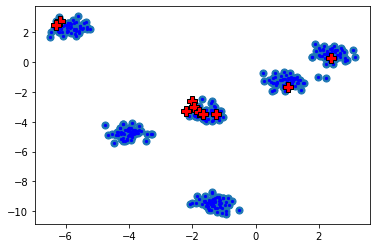

In [4]:
def vis_original_graph_and_clusters(k):
    # Create clusters + scatterplot of points
    X, _ = make_blobs(n_samples=372, centers=6, cluster_std=0.3, random_state=2)
    plt.scatter(X[:, 0], X[:, 1], s=50)

    # Runs your code
    X = X.T
    initializations = first_k(X, k)
    plt.scatter(X[0, :], X[1, :], s=5, cmap='prism', c='b')
    plt.scatter(initializations[0, :], initializations[1 :], s=100, c='r', marker='P', edgecolors='black')

vis_original_graph_and_clusters(10)

Implement `points_to_clusters`, which should return assignments of each datapoint to one of $k$ clusters given the location of $k$ centroids.Given $k$ centroids,   method to assign $n$ points to the closest $j^{th}$ cluster. Recall the use of the Euclidean distance function.

In [5]:
def points_to_clusters(X, centroids):
    '''
    X: A (d x n) matrix of n datapoints of d dimensions
    centroids: A (d x k) matrix where column i represents the position of the ith centroid

    Returns a (1 x n) vector indicating the closest cluster for each datapoint.
    '''
    output = []
    X_new = np.transpose(X)
    cent_new = np.transpose(centroids)
    for point in X_new:
        #now see closest spot
        dist = (float('inf'),None)
        for i in range(len(cent_new)):
            #compute dist
            tent = 0
            for p in range(X.shape[0]):
                tent += (cent_new[i][p] - point[p])**2
            if tent < dist[0]:
                dist = (tent,i)
        output.append(dist[1])
    return np.array([output])

Great! Let's visualize your results from `points_to_clusters`.

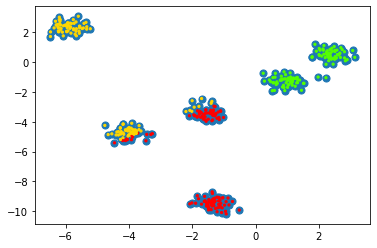

In [6]:
def vis_points_to_clusters(k):
    # Create clusters + scatterplot of points
    X, _ = make_blobs(n_samples=372, centers=6, cluster_std=0.3, random_state=2)
    plt.scatter(X[:, 0], X[:, 1], s=50)

    # Runs your code
    X = X.T
    initializations = first_k(X, k)
    y_kmeans = points_to_clusters(X, initializations)
    plt.scatter(X[0, :], X[1, :], s=5, c=y_kmeans, cmap='prism')

vis_points_to_clusters(3)

<b>2.1.2)</b> Implement `compute_centroids`, a method to update centroids' positions based on a given points and their cluster assignments.

HINT: How should we be updating centroids when no points are assigned to them (this is essential to getting 2.3.1 and 3.2.2 to run succesfully. The code will loop if you do not take this into consideration.)?

HINT: `np.isnan` may be useful here.

In [7]:
def compute_centroids(X, k, cluster_assignments, old_centroids):
    '''
    X: A (d x n) matrix of n datapoints of d dimensions
    k: The number of centroids to estimate using the k-means clustering algorithm
    cluster_assignments: A (1 x n) vector mapping each ith datapoint to its jth cluster
    old_centroids: a (d x k) matrix of the positions of the centroids from the previous iteration.

    Returns a (d x k) matrix indicating the position of each of the centroids.
    '''
    dimensions = X.shape[0]
    centroids = np.zeros((dimensions, k))
    for j in range(k):
        new_centroid = np.mean(X[:, cluster_assignments.squeeze()==j], axis=1)
        if np.isnan(new_centroid).any():
            centroids[:,j] = old_centroids[:,j]
        else:
            centroids[:,j] = np.mean(X[:, cluster_assignments.squeeze()==j], axis=1)
    return centroids

Now that we have a way to update points' assignments to clusters based on their distances from cluster means, we can implement the k-means clustering given a random initialization! We'll look into how we can randomly intialize our centroids in the next section. For now, implement the k-means clustering algorithm given some function to randomly initialize centroids.

HINT:  You can utilize `points_to_clusters` and `compute_centroids` to help you in this section.

In [10]:
def k_means_objective(X, k, cluster_assignments, centroids):
    '''
    X: A (d x n) matrix of n datapoints of d dimensions
    k: The number of centroids to estimate using the k-means clustering algorithm
    cluster_assignments: A (1 x n) vector mapping each ith datapoint to its jth cluster
    centroids: A (d x k) matrix where column i represents the position of the ith centroid

    returns a scalar value representing the k-means objective.
    '''
    num_pts = X.shape[1]
    num_dims = X.shape[0]
    num_cent = centroids.shape[1]
    dist = np.zeros((1,X.shape[1]))
    for i in range(num_cent):
        dist[:,cluster_assignments.squeeze()==i] = np.linalg.norm(X[:,cluster_assignments.squeeze()==i].T - centroids[:,i].T, axis=1).T
    return np.sum(np.square(dist))

def k_means_algorithm(X, k, random_init, return_obj=False):
    centroids = random_init(X,k)
    cluster_assignments = points_to_clusters(X, centroids)
    new_centroids = compute_centroids(X, k, cluster_assignments, centroids)
    while not np.array_equal(centroids,new_centroids):
        centroids = new_centroids
        cluster_assignments = points_to_clusters(X, centroids)
        new_centroids = compute_centroids(X, k, cluster_assignments, centroids)
    final_obj = k_means_objective(X, k, cluster_assignments, centroids)
    if return_obj:
        return centroids, final_obj
    return centroids

Great! Let's visualize your results from `k_means_algorithm`.

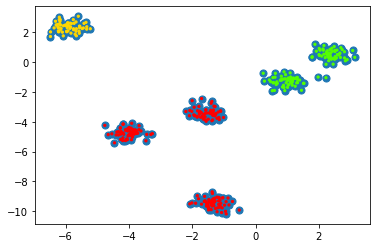

In [11]:
def vis_final_centroids(k):
    # Create clusters + scatterplot of points
    X, _ = make_blobs(n_samples=372, centers=6, cluster_std=0.3, random_state=2)
    plt.scatter(X[:, 0], X[:, 1], s=50)

    # Runs your code
    X = X.T
    final_centroids = k_means_algorithm(X, k, first_k)
    y_kmeans = points_to_clusters(X, final_centroids)
    plt.scatter(X[0, :], X[1, :], s=5, c=y_kmeans, cmap='prism')

vis_final_centroids(3) #Change k!

Now that we have a working k-means clustering algorithm, we'd like to see how it performs! Recall that one way we can evaluate the effectiveness of our model is using the k-means objective.

Implement `k_means_objective`, which given a dataset, a mapping from points to clusters, and the positions of the $k$ centroids, returns the value of the k-means objective.

NOTE: You will need to copy the implementation of `k_means_objective` into `k_means_algorithm` to obtain the answers for the next few problems on the HW.

In [12]:
def k_means_objective(X, k, cluster_assignments, centroids):
    '''
    X: A (d x n) matrix of n datapoints of d dimensions
    k: The number of centroids to estimate using the k-means clustering algorithm
    cluster_assignments: A (1 x n) vector mapping each ith datapoint to its jth cluster
    centroids: A (d x k) matrix where column i represents the position of the ith centroid

    returns a scalar value representing the k-means objective.
    '''
    num_pts = X.shape[1]
    num_dims = X.shape[0]
    num_cent = centroids.shape[1]
    dist = np.zeros((1,X.shape[1]))
    for i in range(num_cent):
        dist[:,cluster_assignments.squeeze()==i] = np.linalg.norm(X[:,cluster_assignments.squeeze()==i].T - centroids[:,i].T, axis=1).T
    return np.sum(np.square(dist))

For this example in particular, we run the algorithm 100000 times then print the average k-means clustering objective value on this dataset using $k=3$.

NOTE: Depending on how you implemented `compute_centroids`, you may get a numpy warning (`RuntimeWarning: invalid value encountered in true_divide`). This is ok as long as your code does not get stuck on calculating centroid updates and you see the console printing out values of `i`.

In [ ]:
objectives = []
def vis_final(k, init_fn):
    # Create clusters + scatterplot of points
    X, _ = make_blobs(n_samples=372, centers=6, cluster_std=0.3, random_state=2)
    plt.scatter(X[:, 0], X[:, 1], s=50)

    # Runs your code
    X = X.T
    for i in range(100000):
        if i % 500 == 0:
            print(i)
        final_centroids, final_objective = k_means_algorithm(X, k, init_fn, return_obj=True)
        objectives.append(final_objective)
    y_kmeans = points_to_clusters(X, final_centroids)
    plt.scatter(X[0, :], X[1, :], s=5, c=y_kmeans, cmap='prism')

vis_final(3, init_fn=close_together_random) 
print(objectives)
print('enter this value for 2.3.1:', sum(objectives) / len(objectives)) 


## 3) Random Initialization?

We started off this homework assignment with two different forms of "random" initializations, `first_k_random` and `close_together_random`. Can we do better, and if so, how much better?

We'll dive deeper into two more types of random initialization methods and observe the results of initialization and final values afterwards.

1. Random initialization of k centroids to k randomly picked datapoints in the dataset.
2. Random initialization of the first point and then random initialization of the remaining $k-1$ points based on a probability proportional to the squared distance away from a given point's nearest existing centroid.

To start off, implement `k_random`, a method to initialize $k$ centroids by uniformally randomly picking $k$ unique datpoints from the dataset.

NOTE: Please use `np.random.permutation(X.shape[1])` to implement `k_random`.

In [ ]:
 def k_random(X, k):
    '''
    X: A (d x n) matrix of n datapoints of d dimensions
    k: The number of centroids to estimate using the k-means clustering algorithm

    Returns a (d x k) matrix indicating k random centroids sampling uniformally from the dataset without replacement.
    '''
    rand = np.random.permutation(X.shape[1])
    cents = X[:,rand[:k]]
    return cents


For this next choice of random initialization, we:

1. Select the first centroid randomly.
2. Calculate the distance for every datapoint not chosen yet between it and its nearest cluster.
3. Choose the datapoint with the largest value in part 2 as the $j^{th}$ centroid.
4. Repeat 2 and 3 until $k$ centroids are initialized.

Implement `proportionally_random_k`, a method to initialize $k$ datapoints based on the method described above.

NOTE: You must use `numpy.random.randint` to generate the first centroid.

In [14]:
def proportionally_random_k(X, k):
    '''
    X: A (d x n) matrix of n datapoints of d dimensions
    k: The number of centroids to estimate using the k-means clustering algorithm

    Returns a (d x k) matrix indicating k random centroids initialized by the steps described above.
    '''
    cents = [X[:,np.random.randint(X.shape[1])]]
    for other_cents in range(k-1):
        dist = []
        for i in range(X.shape[1]):
            point = X[:,i]
            d = float('inf')
            for i in range(len(cents)):
                temp_dist = np.linalg.norm(point-cents[i])
                d = min(d,temp_dist)
            dist.append(d)
        dist = np.array(dist)
        n_cent = X[:,np.argmax(dist)]
        cents.append(n_cent)
        dist = []
    return np.asarray(cents).T


This form of initialization is formally known as "k-means++" initialization. You can read more about it on this <a target="_blank" href="https://en.wikipedia.org/wiki/K-means%2B%2B ">wikipedia page.</a> 

Now that we have four different sets of initialization methods, we'd like to observe how each of them perform. For this example in particular, we use a different dataset and cluster with a value of $k=8$, run the algorithm 1000 times, then print the average k-means clustering objective value.

0
100
200
300
400
500
600
700
800
900
[338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 491.2908657992183, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 403.44054093434306, 491.2908657992183, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 403.44054093434306, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.7397726366841, 338.73977

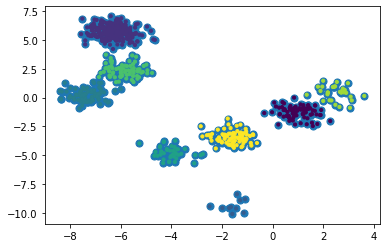

In [15]:
objectives = []
def vis_initializations(k, init_fn):
    # Create clusters + scatterplot of points
    X, _ = make_blobs(n_samples=[10, 80, 80, 80, 40, 30, 80, 300], cluster_std=0.5, random_state=2)
    plt.scatter(X[:, 0], X[:, 1], s=50)
    
    # Runs your code
    X = X.T
    for i in range(1000):
        if i % 100 == 0:
            print(i)
        initializations, final_objective = k_means_algorithm(X, k, init_fn, return_obj=True)
        objectives.append(final_objective)
    y_kmeans = points_to_clusters(X, initializations)
    plt.scatter(X[0, :], X[1, :], c=y_kmeans, s=10)

# Change init_fn!
vis_initializations(8, init_fn=proportionally_random_k)
print(objectives)
print('Enter this value for 3.3.1-3.3.4:', sum(objectives) / len(objectives))


## 5) Putting it all together


## Part 1: Images - Building Intuition with FashionMNIST

We'll start exploring clustering with a simple, intuitive case: clustering the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

The FashionMNIST dataset is a collection of over 60,000 (28x28) greyscale images of various clothing items (e.g. shoes, shirts, bags) that's often used as a nice toy dataset in computer vision circles. While this particular dataset already has labels for each image, we'll be working with the images only. That is, we'll see what patterns in FashionMNIST we can recover without any labels.

**Let's start by loading the dataset and viewing some sample images.**


4431872/4422102 [==============================] - 0s 0us/step
Loaded 2000 images. The first 25 are:


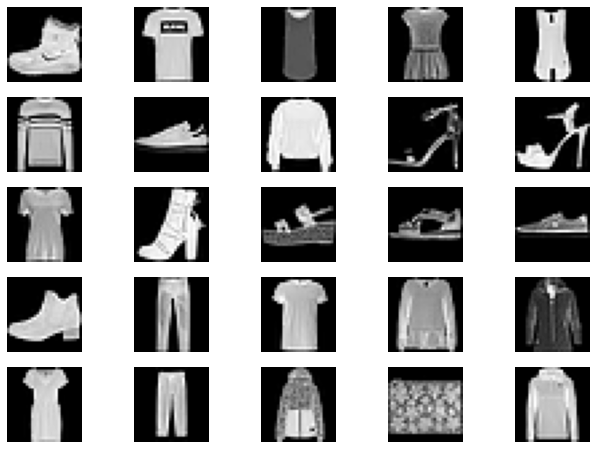

In [16]:
# load dataset
from keras.datasets import fashion_mnist
(fashion_mnist, labels), _ = fashion_mnist.load_data()

# limit to first 2000 images so runtimes are reasonable
fashion_mnist = fashion_mnist[:2000, :, :]

# Show the first 25 images as a sample
print(f"Loaded {fashion_mnist.shape[0]} images. The first 25 are:")
sns.set(rc={'figure.figsize':(11,8)})
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(fashion_mnist[i], cmap=plt.get_cmap('gray'))
    plt.axis("off")
plt.show()

To cluster the images, we'll need to convert the images into a format we can pass into our KMeans model, which expects 1D feature vectors. For this assignment, we'll just flatten our image. This is akin to cutting each image up into rows, and concatenating the rows end-to-end to form one long, skinny image.

Note that this is a rather naive way to vectorize our images, and there are definitely better ways to represent images for clustering. We'll stick with this for now to keep things simple.

In [17]:
# squash images into 1D
fashion_data = fashion_mnist.reshape((-1, 28*28))

**Now run the code box below using different numbers of clusters, and note how the clustering results change.**

In [ ]:
# cluster the images
k = 10 # CHANGE ME!
centroids = k_means_algorithm(fashion_data.T, k, proportionally_random_k)
labels = points_to_clusters(fashion_data.T, centroids)

clusters = {n:[] for n in range(k)}
for i in range(fashion_data.shape[0]):
  key = labels[0][i]
  value = fashion_data[i,:].reshape(1, 28, 28).squeeze()
  clusters[key].append(value)

# display images from each cluster
sns.set(rc={'figure.figsize':(6,4)})
for cluster_num, images in clusters.items():
  print(f'Cluster {cluster_num} contains {len(images)} images. The first 25 are:')
  for i in range(min(25, len(images))):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.axis("off")
  # show the figure
  plt.show()

<b>5.1.1)</b> What value of $k$ results in clusters that are most meaningful?

<b>5.1.2)</b> When might you want to use a smaller grouping?

<b>5.1.3)</b> After looking at the results, why might $k = 15$ not be a good value of $k$ for the Fashion MNIST dataset?

<b>5.2.1)</b> Run the k-means clustering algorithm on $k = 2$ again. What features of the images does KMeans seem to be using to split the data into two groups?

<b>5.2.2)</b> Now run the k-means clustering algorithm on both $k = 8$ and $k = 10$. Which items or traits group together in $k = 8$ compared to $k = 10$?

## Part 2: Real-World Data

Now that we've built up some intuition on what k-means does, let's try clustering on some more complex, real world data. We've provided a list of the DCIDs of just over 100 different countries around the world, along with a list of DCIDs statistical variables to start out with.

In case the DCID names are unclear, we'll be looking at the following statistics for each country:
* CO2 emissions per capita
* Life expectancy
* Number of internet users per capita
* Population growth rate
* Percentage of population that is overweight
* [Gini Index](https://www.investopedia.com/terms/g/gini-index.asp) (A measure of economic inequality)
* Percentage of population with mobile phone subscriptions
* [Gross domestic product](https://en.wikipedia.org/wiki/Gross_domestic_product) per captia
* [Fertility rate](https://data.oecd.org/pop/fertility-rates.htm)
* Number of deaths per year, normalized by population

Run the following code boxes to load and cluster the data associated with each country. 


In [ ]:
dcids = [
  'country/AGO', 'country/ALB', 'country/ARG', 'country/ARM', 'country/AUS',
  'country/AZE', 'country/BDI', 'country/BGD', 'country/BGR', 'country/BIH',
  'country/BLZ', 'country/BOL', 'country/BRA', 'country/BTN', 'country/BWA',
  'country/CAN', 'country/CHL', 'country/CHN', 'country/CMR', 'country/COD',
  'country/COG', 'country/COL', 'country/CRI', 'country/CZE', 'country/DOM',
  'country/DZA', 'country/ECU', 'country/EGY', 'country/ETH', 'country/FJI',
  'country/GAB', 'country/GEO', 'country/GHA', 'country/GTM', 'country/GUY',
  'country/HND', 'country/IDN', 'country/IND', 'country/IRN', 'country/JAM',
  'country/JOR', 'country/JPN', 'country/KAZ', 'country/KEN', 'country/KGZ',
  'country/KIR', 'country/KOR', 'country/LAO', 'country/LBN', 'country/LCA',
  'country/LSO', 'country/MAR', 'country/MDA', 'country/MDG', 'country/MEX',
  'country/MKD', 'country/MLI', 'country/MMR', 'country/MNE', 'country/MNG',
  'country/MOZ', 'country/MRT', 'country/MWI', 'country/MYS', 'country/NAM',
  'country/NER', 'country/NGA', 'country/NIC', 'country/NPL', 'country/PAK',
  'country/PAN', 'country/PER', 'country/PHL', 'country/PNG', 'country/PRY',
  'country/ROU', 'country/RWA', 'country/SDN', 'country/SLV', 'country/SRB',
  'country/SWZ', 'country/SYR', 'country/THA', 'country/TJK', 'country/TKM',
  'country/TLS', 'country/TON', 'country/TTO', 'country/TUN', 'country/TUR',
  'country/TZA', 'country/UGA', 'country/UKR', 'country/USA', 'country/UZB',
  'country/VNM', 'country/VUT', 'country/WSM', 'country/YEM', 'country/ZAF',
  'country/ZMB', 'country/ZWE'
]


stat_vars_to_query = [
  "Amount_Emissions_CarbonDioxide_PerCapita",
  "LifeExpectancy_Person",
  "Count_Person_IsInternetUser_PerCapita",
  "GrowthRate_Count_Person",
  "Count_Person_Upto4Years_Overweight_AsFractionOf_Count_Person_Upto4Years",
  "GiniIndex_EconomicActivity",
  "Count_Product_MobileCellularSubscription_AsFractionOf_Count_Person",
  "Amount_EconomicActivity_GrossDomesticProduction_Nominal_PerCapita",
  "FertilityRate_Person_Female",
  "Count_Death_AsAFractionOfCount_Person"
]

df = datacommons_pandas.build_multivariate_dataframe(dcids,stat_vars_to_query)

# swap index for names
df.insert(0, 'name', df.index.map(datacommons.get_property_values(df.index, 'name')).str[0])
df.set_index('name', drop=True, inplace=True)

display(df)

### The Importance of Normalization
Scroll through the dataframe generated by the codebox above, and take note of the scales of each of the features. They can vary drastically in magnitude! Let's normalize our data before clustering.

In [ ]:
# normalize the values
mean_df = df.mean()
std_df = df.std()
normalized_df = ((df-mean_df)/std_df)
display(normalized_df)

<b>5.3.1)</b> We normalize the data before we run the k-means clustering algorithm. What would happen if we didn't pre-process the dataset?

### Interpreting Clusters
Now let's cluster our data! Once again, play around with $k$ to see how the results change. 

In [ ]:
# Clustering using K-means
n_clusters = 3 # CHANGE ME!
kmeans_model = KMeans(n_clusters, random_state=42).fit(normalized_df)
labels_df = pd.DataFrame(data=np.transpose(kmeans_model.labels_), index=normalized_df.index, columns=['cluster'])

# list countries in each cluster:
for i in range(n_clusters):
  print(f'Countries in Cluster {i}:')
  print(labels_df.index[labels_df['cluster']==i].tolist())
  print(len(labels_df.index[labels_df['cluster']==i].tolist()))

#### Analyzing Centroids

What characterizes each of the clusters?

It can be a little hard to tell what characteristics each cluster has latched on to from cluster membership alone. One way to characterize clusters is to look at the **centroids**, which are the average values of each cluster. One can think of the centroids as describing the average group member.

Run the following code box to display the values of the centroids of each cluster. *Note: We're displaying the non-normalized values for better interpretability. The clustering was still performed on normalized values.*

In [ ]:
# Get centroids of each cluster.
for i in range(n_clusters):
  print(f'\nCluster {i}:')
  # display non-normalized mean values
  mean_to_display = df[labels_df['cluster']==i].mean()
  display(mean_to_display)

#### Visualizing Centroids
These values can be difficult to compare on their own. One good way to visualize cluster centroids is by using a color-coded heatmap of normalized values. Use the code box below to generate such a heat map.

In [ ]:
# get normalized values
normalized_means = []
for i in range(n_clusters):
  # calculate normalized values for the next part
  mean_normalized = normalized_df[labels_df['cluster']==i].mean()
  normalized_means.append(mean_normalized.to_frame().transpose())
normalized_means_df = pd.concat(normalized_means)

# For better visualization, we'll multiply the following features by -1
# so that a higher value is associated with more development.

features_to_flip = [
  "GiniIndex_EconomicActivity",
  "GrowthRate_Count_Person",
  "FertilityRate_Person_Female"
]

for column in features_to_flip:
  normalized_means_df[column] *= -1

# Plot heatmap
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale = 1.5)
ax = sns.heatmap(normalized_means_df.to_numpy(), linewidth=0.5, xticklabels=normalized_means_df.columns, center=0)
ax.set_ylabel("Cluster")
plt.show()

<b>5.3.2)</b> What does each cluster seem to represent?

Run the code box below to get feature values for each country that can help you answer the next three questions.


In [ ]:
dcids_holdout = ['country/HTI','country/DEU', 'country/IRQ']

# get values for each holdout
df_holdout = datacommons_pandas.build_multivariate_dataframe(dcids_holdout,stat_vars_to_query)
df_holdout = df_holdout.dropna()

# swap index for names
df_holdout.insert(0, 'name', df_holdout.index.map(datacommons.get_property_values(df_holdout.index, 'name')).str[0])
df_holdout.set_index('name', drop=True, inplace=True)

# show values
display(df_holdout)

# normalized version for clustering later
normalized_df_holdout = ((df_holdout-mean_df)/std_df)

<b>5.3.3)</b> Based on the feature values and cluster centroids produced, which cluster would Germany most likely belong to?

<b>5.3.4)</b> Based on the feature values and cluster centroids produced, which cluster would Haiti most likely belong to?

<b>5.3.5)</b> Based on the feature values and cluster centroids produced, which cluster would Iraq most likely belong to?